In [ ]:
from keybert import KeyBERT
import json
import pandas as pd
import concurrent.futures
from sentence_transformers import SentenceTransformer

top_n_vals = [5, 10, 50, 100, 500, 1000]

cranfield = []
with open("cranfield/cran_docs.json", "r") as f:
    cranfield = json.load(f)

body_list = [data['body'] for data in cranfield]
combined_text = " ".join(body_list)

# Load the model and tokenizer explicitly
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

def get_keywords(text, top_n, model):
    # Initialize KeyBERT with the loaded model
    kw_model = KeyBERT(model=model)

    # Extract keywords
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 1),
        stop_words="english",
        use_mmr=True,
        top_n=top_n
    )

    # Save keywords to a CSV file
    df = pd.DataFrame(keywords, columns=['Keyword', 'Score'])
    df.to_csv(f"topics/topics_top_{top_n}.csv", index=False)
    return None


with concurrent.futures.ThreadPoolExecutor() as executor:
    # Extract keywords in parallel
    keyword_results = list(executor.map(get_keywords, [combined_text]*len(top_n_vals), top_n_vals, [model]*len(top_n_vals)))


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
import requests
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, filename='wiki_summary.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')

def get_wikipedia_summary(keyword, max_attempts=3):
    headers = {'User-Agent': 'NLP IR agent'}
    search_url = "https://en.wikipedia.org/w/api.php"

    # Search Wikipedia for the keyword
    search_params = {
        'action': 'query',
        'list': 'search',
        'srsearch': keyword,
        'format': 'json'
    }
    search_response = requests.get(search_url, params=search_params, headers=headers)
    search_data = search_response.json()

    search_hits = search_data.get('query', {}).get('search', [])

    # Try multiple hits (up to max_attempts)
    for idx, hit in enumerate(search_hits[:max_attempts]):
        title = hit['title']
        
        # Get the summary
        summary_params = {
            'action': 'query',
            'prop': 'extracts|categories',
            'exintro': True,
            'explaintext': True,
            'titles': title,
            'format': 'json'
        }
        summary_response = requests.get(search_url, params=summary_params, headers=headers)
        summary_data = summary_response.json()

        pages = summary_data.get('query', {}).get('pages', {})
        if pages:
            page = next(iter(pages.values()))
            summary = page.get('extract')
            categories = [cat['title'] for cat in page.get('categories', [])] if 'categories' in page else []

            # Check for disambiguation indicators
            if summary:
                is_disambig = ("disambiguation pages" in " ".join(categories).lower() or
                               "may refer to" in summary.lower() or
                               "may stand for" in summary.lower())
                
                if not is_disambig:
                    # Good summary found
                    logging.info(f"Found summary for '{keyword}'")  # Print first 100 characters
                    return summary
                else:
                    logging.info(f"Disambiguation detected for '{title}', trying next result...")

    # Fallback to dictionary definition
    synsets = wordnet.synsets(keyword)
    if synsets:
        return synsets[0].definition()

    return None

lemmatizer = WordNetLemmatizer()

for i in top_n_vals:

    df = pd.read_csv(f"topics/topics_top_{i}.csv")
    df['Keyword'] = df['Keyword'].apply(lambda x: lemmatizer.lemmatize(x))
    df.to_csv(f"topics/topics_top_{i}_lem.csv", index=False)

    # Get Wikipedia summaries in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Extract Wikipedia summaries in parallel
        wiki_results = list(executor.map(get_wikipedia_summary, df['Keyword']))

    # Save Wikipedia summaries to a json
    wiki_summaries = {df['Keyword'][i]: wiki_results[i] 
                      for i in range(len(wiki_results))
                      if wiki_results[i] is not None}
    with open(f"topics/topics_top_{i}_lem_wiki.json", "w") as f:
        json.dump(wiki_summaries, f, indent=4)

In [11]:
import json
import logging
import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
#import wikipediaapi
from nltk.corpus import stopwords

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", filename="debug.log")
logger = logging.getLogger(__name__)

def preprocess_text(text):

    '''
    Preprocess the text by tokenizing, removing stop words, and lemmatizing.
    Args:
        text (str): The input text to preprocess.
    Returns:
        str: The preprocessed text.
    '''

    # Ensure nltk data is available when called by the Spark job later. 
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    nltk.data.path.append("./nltk_data")

    if not text:
        return ""
    # Tokenize the text
    tokens = word_tokenize(text.lower()) 
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)  # Return as a string

def clean_text(text):
    '''
    Clean the text by removing non-alphanumeric characters and converting to lowercase.
    (helper function)
    '''
    text = re.sub(r"\W+", " ", text.lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text


def load_corpus(corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Load the corpus from a JSON file.
    Args:
        corpus_file (str): Path to the JSON file containing the corpus.
    Returns:
        dict: The loaded corpus as a dictionary.
    '''

    try:
        with open(corpus_file, "r") as file:
            corpus_dict = json.load(file)
        logger.info(f"Corpus successfully loaded from {corpus_file}.")
        return corpus_dict
    except Exception as e:
        logger.error(f"Failed to load corpus from {corpus_file}: {e}")
        return {}


def generate_esa_vectors(text, corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Generate ESA vectors for the given text using the lemmatized corpus.
    Args:
        text (str): The input text to generate ESA vectors for.
    Returns:
        list: The ESA vectors for the input text.
    '''
    
    logger.info("Generating ESA vectors.")
    
    corpus = load_corpus(corpus_file)  # Load the corpus
    if not corpus:
        logger.error("Corpus is empty or could not be loaded.")
        return [], []

    # preprocessing 
    sentences = sent_tokenize(text)
    processed_sentences = [preprocess_text(s) for s in sentences]
    processed_corpus = list(corpus.values())
    all_documents = processed_sentences + processed_corpus

    vectorizer = TfidfVectorizer(stop_words="english")          # Create a TF-IDF vectorizer
    tfidf_matrix = vectorizer.fit_transform(all_documents)      # Fit and transform the documents

    esa_vectors = []
    # Generate ESA vectors for each processed sentence
    for i in range(len(processed_sentences)):
        similarities = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[len(processed_sentences):])
        esa_vector = similarities.flatten()
        esa_vectors.append(esa_vector)
    
    if esa_vectors:         # ESA vectors are generated
        esa_vectors = np.mean(esa_vectors, axis=0)
        return esa_vectors.tolist()
    else:
        logger.error("No ESA vectors generated.")
    return []

def main():
    '''
    Main function to run the ESA vector generation.
    '''
    # Example text
    text = "what are the structural and aeroelastic problems associated with flight of high speed aircraft ."
    
    # Generate ESA vectors for the example text
    esa_vectors = generate_esa_vectors(text, corpus_file="topics/topics_top_100_lem_wiki.json")
    
    if esa_vectors:
        print("ESA Vectors generated successfully.")
        print(esa_vectors)
    else:
        print("Failed to generate ESA vectors.")

if __name__ == "__main__":
    main()

ESA Vectors generated successfully.
[0.04342979505589475, 0.04640800668249069, 0.0, 0.027954005902964922, 0.02406387250442451, 0.0, 0.0, 0.0, 0.0, 0.023044563654779124, 0.0, 0.07062269908285612, 0.0, 0.0, 0.0, 0.01799739009632362, 0.0, 0.0, 0.1082423997033001, 0.07941038983369746, 0.0, 0.12156259885002085, 0.015615036318567189, 0.0, 0.0, 0.0, 0.0, 0.00880664186339722, 0.0235845400496438, 0.0, 0.0, 0.0, 0.008940808214708001, 0.0, 0.011389587661507413, 0.0, 0.02406387250442451, 0.007244661688261004, 0.022435669909016204, 0.0, 0.026115014533331985, 0.022265397962379443, 0.0, 0.0, 0.03292030801921773, 0.0, 0.0, 0.0, 0.0, 0.01707111308782621, 0.0, 0.0, 0.0, 0.0, 0.04798261594986034, 0.031591763781367875, 0.0, 0.008237621245766666, 0.029253269937733938, 0.07069755830099819, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05769821765074466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01276409730331843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
cranfield = []
with open("cranfield/cran_docs.json", "r") as f:
    cranfield = json.load(f)
    f.close()
bodies = {data['id']:data['body'] for data in cranfield}
    
corpus_sizes = [5, 10, 50, 100, 500, 1000]

In [13]:
from collections import defaultdict

for corpus_size in corpus_sizes:
    
    esa_dict = defaultdict()
    
    for doc_id, doc_body in bodies.items():
        esa_dict[doc_id] = generate_esa_vectors(doc_body, corpus_file=f"topics/topics_top_{corpus_size}_lem_wiki.json")
    
    with open(f"topics/topics_top_{corpus_size}_docs_esa.json", "w") as f:
        json.dump(esa_dict, f)

KeyboardInterrupt: 

In [14]:
import json
import numpy as np

class ESAInformationRetrieval:
    
    def __init__(self, corpus_size=1000):
        
        self.corpus_size = corpus_size
        self.docIDs = []
        self.docVectors = None
    
    def build_vectors(self):
        
        with open(f"topics/topics_top_{self.corpus_size}_docs_esa.json", "r") as f:
            doc_esa_vectors = json.load(f)
            f.close()
        self.docIDs = [int(doc_id) for doc_id in doc_esa_vectors.keys()]
        self.docVectors = np.array([x for x in list(doc_esa_vectors.values()) if len(x) != 0])
    
    def rank(self, query):
        
        queryVector = generate_esa_vectors(query, corpus_file=f"topics/topics_top_{self.corpus_size}_lem_wiki.json")
                
        sim_matrix = cosine_similarity(np.array(queryVector).reshape(1, -1), self.docVectors)
              
        for row in sim_matrix:
            ranked_indices = np.argsort(-row)
            ranked_docIDs = [self.docIDs[i] for i in ranked_indices]
            
        return ranked_docIDs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import Evaluation

for corpus_size in corpus_sizes:
    ir = ESAInformationRetrieval(corpus_size=corpus_size)
    ir.build_vectors()

    queries_json = json.load(open("cranfield/cran_queries.json", 'r'))
    qrels = json.load(open("cranfield/cran_qrels.json", 'r'))

    query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]


    evaluator = Evaluation()

    doc_IDs_ordered = [ir.rank(query) for query in queries]

    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

    for k in range(1, 11):
        precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)
        recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)
        fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
        fscores.append(fscore)
        #print("Precision, Recall and F-score @ " + str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
        MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
        MAPs.append(MAP)
        nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(nDCG)
        #print("MAP, nDCG @ " + str(k) + " : " + str(MAP) + ", " + str(nDCG))
    
    # Plot the metrics and save plot 
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    plt.plot(range(1, 11), precisions, label="Precision")
    plt.plot(range(1, 11), recalls, label="Recall")
    plt.plot(range(1, 11), fscores, label="F-Score")
    plt.plot(range(1, 11), MAPs, label="MAP")
    plt.plot(range(1, 11), nDCGs, label="nDCG")
    plt.legend()
    plt.title(f"Evaluation Metrics - Corpus Size = {corpus_size}")
    plt.xlabel("k")

    plt.show()
    plt.savefig(f"esa/eval_plot{corpus_size}.png")


In [21]:
ir = ESAInformationRetrieval(corpus_size=10)

In [22]:
ir.build_vectors()

In [23]:
queries_json = json.load(open("cranfield/cran_queries.json", 'r'))
qrels = json.load(open("cranfield/cran_qrels.json", 'r'))

In [24]:
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

In [25]:
from evaluation import Evaluation

evaluator = Evaluation()

In [ ]:
doc_IDs_ordered = [ir.rank(query) for query in queries]

precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

for k in range(1, 11):
    precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
    precisions.append(precision)
    recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
    recalls.append(recall)
    fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
    fscores.append(fscore)
    print("Precision, Recall and F-score @ " + str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
    MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
    MAPs.append(MAP)
    nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
    nDCGs.append(nDCG)
    print("MAP, nDCG @ " + str(k) + " : " + str(MAP) + ", " + str(nDCG))



Precision, Recall and F-score @ 1 : 0.017777777777777778, 0.0023703703703703703, 0.004114959114959115
MAP, nDCG @ 1 : 0.0023703703703703703, 0.017777777777777778
Precision, Recall and F-score @ 2 : 0.013333333333333334, 0.003116402116402116, 0.004843863471314452
MAP, nDCG @ 2 : 0.0027433862433862435, 0.023386042253968512
Precision, Recall and F-score @ 3 : 0.011851851851851851, 0.003857142857142857, 0.005549548355749905
MAP, nDCG @ 3 : 0.0030890652557319224, 0.02525146798351601
Precision, Recall and F-score @ 4 : 0.011111111111111112, 0.004462081128747795, 0.005977938890219592
MAP, nDCG @ 4 : 0.003268077601410935, 0.027254435691556316
Precision, Recall and F-score @ 5 : 0.010666666666666668, 0.007573192239858907, 0.007700497033830368
MAP, nDCG @ 5 : 0.0038902998236331567, 0.03069312731141891
Precision, Recall and F-score @ 6 : 0.013333333333333334, 0.010736331569664904, 0.010633966677444937
MAP, nDCG @ 6 : 0.004491563786008231, 0.03871986939471226
Precision, Recall and F-score @ 7 : 0.

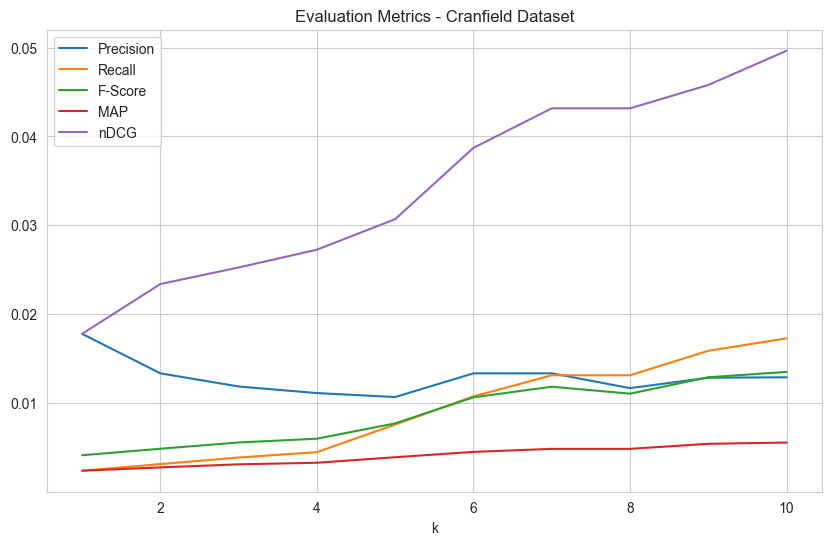

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the metrics and save plot 
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(range(1, 11), precisions, label="Precision")
plt.plot(range(1, 11), recalls, label="Recall")
plt.plot(range(1, 11), fscores, label="F-Score")
plt.plot(range(1, 11), MAPs, label="MAP")
plt.plot(range(1, 11), nDCGs, label="nDCG")
plt.legend()
plt.title("Evaluation Metrics - Cranfield Dataset")
plt.xlabel("k")

plt.show()